<a href="https://colab.research.google.com/github/kopokopok/ds202/blob/main/lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: ProPublica's Analysis of the COMPAS Tool

In 2016, [ProPublica published an analysis](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of the Correctional Offender Management Profiling for Alternative Sanctions (COMPAS) tool. COMPAS is a proprietary tool which generates a so-called risk assessment for defendants in a criminal trial. ProPublica's analysis focused on the "recidivism score," which purports to provide the likelihood of recidivism (i.e. committing a misdemeanor of felony) within two years of assessment.

In this lab, we will go through parts of ProPublica's analysis of COMPAS, focusing on how the recidivism risk scale varies by race and sex.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the COMPAS recidivism score, our primary variable of interest
3. Reproduce the logistic regression model in ProPublica's analysis and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

# Packages and Modules

You may need to install the following packages:




In [1]:
%pip install pandas numpy statsmodels matplotlib seaborn

Import the packages and modules:


In [2]:
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

Import the data from ProPublica's compas-analysis repository on GitHub and check the first few rows:

In [3]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)
print("Shape: ", df_compas.shape)
df_compas.head(5)

Shape:  (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Notes on the Data

Refer to the description of the [data collection methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm). Salient points are highlighted below; see the full description from ProPublica for additional details.

> **Goal:** We looked at more than 10,000 criminal defendants in Broward County, Florida, and compared their predicted recidivism rates with the rate that actually occurred over a two-year period.
>
> **COMPAS tool input (data subjects):** When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of Risk of Recidivism and Risk of Violent Recidivism.
>
> **How COMPAS input was acquired by ProPublica:** Through a public records request, ProPublica obtained two years worth of COMPAS scores from the Broward County Sheriff’s Office in Florida. We received data for all 18,610 people who were scored in 2013 and 2014.
>
> **COMPAS tool output:** Each pretrial defendant received at least three COMPAS scores: "Risk of Recidivism," "Risk of Violence" and "Risk of Failure to Appear. [...] COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as "Low;" 5 to 7 were labeled “Medium;" and 8 to 10 were labeled “High.”
>
> **Data integration (record linkage):** Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016. On average, defendants in our dataset were not incarcerated for 622.87 days (sd: 329.19). We matched the criminal records to the COMPAS records using a person’s first and last names and date of birth. This is the same technique used in the Broward County COMPAS validation study conducted by researchers at Florida State University in 2010. We downloaded around 80,000 criminal records from the Broward County Clerk’s Office website.
>
> **What is recidivism?** Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored. [...] For most of our analysis, we defined recidivism as a new arrest within two years.

# Inspect Data

For convenience, here is a table of variable definitions:

| Variable    | Description |
| ----------- | ----------- |
| age       |  Age of the defendant   |
| age_cat   |  Age category. It can be < 25, 25-45, >45    |
| sex   |  Sex of the defendant. It is either "Male" or "Female"       |
| race   |  Race of the defendant. It can be "African-American", "Caucasian", "Hispanic", "Asian", or "Other"      |
| c_charge_degree   |   Charge. Either "M" for misdemeanor, "F" for felony, or "O" (not causing jail time)    |
| priors_count   |   Count of prior crimes committed by the defendant      |
| days_b_screening_arrest   |  Days between the arrest and COMPAS screening       |
| decile_score   |  The COMPAS score estimated by the system. It is between 0-10       |
| score_text   |  Decile score. It can be "Low" (1-4), "Medium" (5-7), or "High" (8-10)       |
| is_recid   |  Indicates if the defendant recidivated. It can be 0, 1, or -1      |
| two_year_recid   |  Indicates if the defendant recidivated within two years of COMPAS assessment      |
| c_jail_in   |   Date the defendant was in jail      |
| c_jail_out  |   Date when the defendant was released from jail     |

\
Plot the distribution of age, race, and sex in the imported data (```df_compas```):

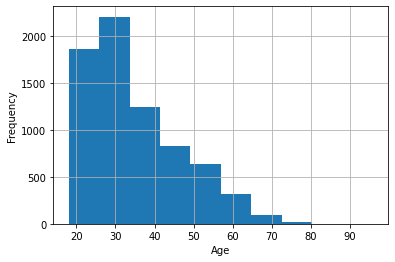

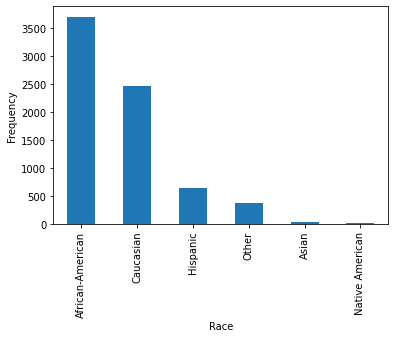

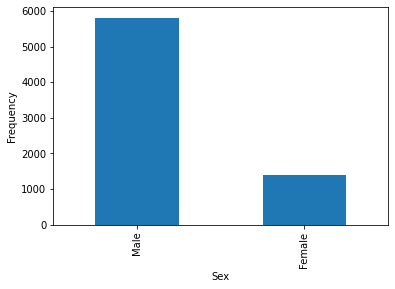

In [10]:
# write code to plot the distribution of age, race, and sex
# in this code cell
df_compas['age'].hist()
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

df_compas['race'].value_counts().plot(kind='bar')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.show()

df_compas['sex'].value_counts().plot(kind='bar')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.show()

# Preprocess Data

ProPublica implemented a few pre-processing steps. First, they generated a subset of the data with a few variables of interest. Here, we select even fewer variables, keeping only those that we will use in this notebook.

In [11]:
cols_to_keep = ["id", "age", "c_charge_degree", "race", "age_cat", "score_text",
                "sex", "priors_count", "days_b_screening_arrest",
                "decile_score", "is_recid", "two_year_recid"]

df_selected = df_compas[cols_to_keep].copy()

print("Shape: ", df_selected.shape)
df_selected.head()

Shape:  (7214, 12)


,id,age,c_charge_degree,race,age_cat,score_text,sex,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid
0,1,69,F,Other,Greater than 45,Low,Male,0,-1.0,1,0,0
1,3,34,F,African-American,25 - 45,Low,Male,0,-1.0,3,1,1
2,4,24,F,African-American,Less than 25,Low,Male,4,-1.0,4,1,1
3,5,23,F,African-American,Less than 25,High,Male,1,NaN,8,0,0
4,6,43,F,Other,25 - 45,Low,Male,2,NaN,1,0,0


Take a moment to get a feel for the variables and structure of the data. ProPublica filtered the above data by removing rows where:

1. The COMPAS score is missing.
1. The charge date of the defendant's COMPAS-scored crime was not within 30 days from the date of arrest. ProPublica assumed that the offense may not be correct in these cases.
2. The recividist flag is "-1". In such cases, ProPublica could not find a COMPAS record at all.
3. The charge is "O". These are ordinary traffic offenses and do not result in jail time.

We implement these conditions here:

In [12]:
df_analysis = df_selected[
    (df_selected.score_text != "N/A") &
    (df_selected.days_b_screening_arrest <= 30) &
    (df_selected.days_b_screening_arrest >= -30) &
    (df_selected.is_recid != -1) &
    (df_selected.c_charge_degree != "O")
    ].copy()

Note that ProPublica only included people who had recidivated within two years or had at least two years outside a correctional facility. This pre-processing step is "baked in" to the data that we imported from GitHub in this notebook.

Check the dimensions (i.e. the number of variables and observations) of the imported (```df_compas```) and preprocessed (```df_analysis```) data:

In [13]:
# write code to check the number of variables and observations in df_compas
# and df_analysis here
print(df_compas.shape)
print(df_analysis.shape)

(7214, 53)
(6172, 12)


Take the additional step of making sure that the decile score (discussed below) is numeric:


In [14]:
df_analysis["decile_score"] = pd.to_numeric(df_analysis["decile_score"])

# Inspect Data Again

Re-inspect salient variables in the data after the preprocessing steps. Plot the distribution of age, race, and sex in the preprocessed data (```df_analysis```) and compare these distributions to the imported data (```df_compas```):

In [15]:
# write code to plot the distribution of age, race, and sex in 
# the df_analysis data

Observe that we are iterating through the data analysis: import, inspect & profile, preprocess, and profile again. Generate a crosstab summarizing the number of observations by race and sex:

In [16]:
# write code to generate a crosstab summarizing the number of observations by
# race and sex (i.e. a pivot table) in this code cell

# Exploratory Analysis

Let's turn our focus to the primary variable of interest: the COMPAS recidivism score. In this exploratory analysis, we are interested in the variable named "decile_score".

The ProPublica analysis notes: "Judges are often presented with two sets of scores from the COMPAS system: one that classifies people into high, medium or low risk, and a corresponding decile score."

Plot the distribution of decile score for males and for females. To what extent do these distributions differ?

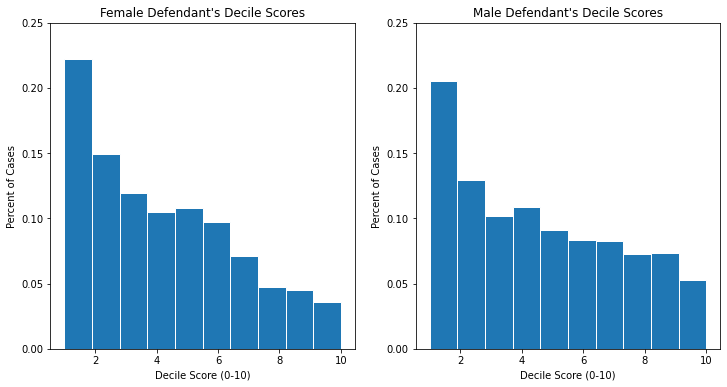

In [17]:
# plot score decile by sex
df_female = df_analysis[(df_analysis.sex == "Female")].copy()
df_male   = df_analysis[(df_analysis.sex == "Male")].copy()

fig = plt.figure(figsize = (12, 6))
fig.add_subplot(121)

plt.hist(df_female["decile_score"], ec = "white",
         weights = np.ones(len(df_female["decile_score"])) /
         len(df_female["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Female Defendant's Decile Scores")
plt.ylim([0, 0.25])

fig.add_subplot(122)
plt.hist(df_male["decile_score"], ec = "white",
         weights = np.ones(len(df_male["decile_score"])) /
         len(df_male["decile_score"]))
plt.xlabel("Decile Score (0-10)")
plt.ylabel("Percent of Cases")
plt.title("Male Defendant's Decile Scores")
plt.ylim([0, 0.25])

plt.show()

What about race? Repeat the above plots for Black defendants and White defendants:

In [18]:
# write code to plot "decile_score" for White and Black defendants
# in this code cell

**Summarize the difference between the distribution of decile scores for Black defendants and White defendants in this text cell (three sentences maximum):**

Plot the distribution of COMPAS-assigned "risk labels" (the variable is named "score_text") for Black defendants and White defendants:

In [19]:
# plot the distribution of "score_text" for White defendants and 
# Black defendants in this code cell

# Bias in COMPAS

ProPublica focused on racial bias in the COMPAS algorithm. In general terms, ProPublica analyzed (i) how the *risk scores* vary by race and (ii) the extent to which the *risk labels* assigned to defendants matches up with their observed recidivism and how this varies by race. We will (approximately) reproduce this analysis below.

## Preprocess Data for Logistic Regression

ProPublica used a logistic regression model to analyze variation in the risk scores by race. We will prepare the data by one-hot encoding the categorical variables.

In [20]:
print(df_analysis.dtypes)

id                           int64
age                          int64
c_charge_degree             object
race                        object
age_cat                     object
score_text                  object
sex                         object
priors_count                 int64
days_b_screening_arrest    float64
decile_score                 int64
is_recid                     int64
two_year_recid               int64
dtype: object


In [21]:
for i, col_type in enumerate(df_analysis.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            df_analysis.columns[i],
            df_analysis[df_analysis.columns[i]].unique()))


Variable c_charge_degree takes the values: ['F' 'M']

Variable race takes the values: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']

Variable age_cat takes the values: ['Greater than 45' '25 - 45' 'Less than 25']

Variable score_text takes the values: ['Low' 'Medium' 'High']

Variable sex takes the values: ['Male' 'Female']


In [22]:
df_logistic = df_analysis.copy()

# one-hot encoding
df_logistic = pd.get_dummies(df_logistic,
                             columns = ["c_charge_degree", "race",
                                        "age_cat", "sex"])

# mutate score_text to binary variable where low = {low}
# and high = {medium, high}
df_logistic["score_binary"] = np.where(df_logistic["score_text"] != "Low",
                                       "High", "Low")
df_logistic["score_binary"] = df_logistic["score_binary"].astype('category')

# rename the columns to be more instructive and consistent with statsmodel
# requirements for variable names
df_logistic.columns = df_logistic.columns.str.replace(' ', '_')
df_logistic.columns = df_logistic.columns.str.replace('-', '_')

renamed_cols = {'age_cat_25___45':'age_cat_25_to_45',
                'c_charge_degree_F':'Felony',
                'c_charge_degree_M':'Misdemeanor'}

df_logistic = df_logistic.rename(columns = renamed_cols)



Check that recoding resulted in the desired data structure:

In [23]:
df_logistic.head()

,id,age,score_text,priors_count,days_b_screening_arrest,decile_score,is_recid,two_year_recid,Felony,Misdemeanor,race_African_American,race_Asian,race_Caucasian,race_Hispanic,race_Native_American,race_Other,age_cat_25_to_45,age_cat_Greater_than_45,age_cat_Less_than_25,sex_Female,sex_Male,score_binary
0,1,69,Low,0,-1.0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,Low
1,3,34,Low,0,-1.0,3,1,1,1,0,1,0,0,0,0,0,1,0,0,0,1,Low
2,4,24,Low,4,-1.0,4,1,1,1,0,1,0,0,0,0,0,0,0,1,0,1,Low
5,7,44,Low,0,0.0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,Low
6,8,41,Medium,14,-1.0,6,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,High


## Estimate Logistic Regression Model

Following ProPublica, we specify the following logistic regression model:

In [24]:
# Right-hand side
explanatory = "priors_count + two_year_recid + Misdemeanor + \
age_cat_Greater_than_45 + age_cat_Less_than_25 + \
race_African_American + race_Asian + race_Hispanic + race_Native_American + \
race_Other + sex_Female"

# Left-hand side
response = "score_binary"

# Formula
formula = response + " ~ " + explanatory
print(formula)

score_binary ~ priors_count + two_year_recid + Misdemeanor + age_cat_Greater_than_45 + age_cat_Less_than_25 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + sex_Female


Let's fit the model:

In [25]:
# Note: using family = sm.families.Binomial() specifies a logistic regression
model = sm.formula.glm(formula = formula, 
                       family = sm.families.Binomial(),
                       data = df_logistic).fit()

print(model.summary())

                              Generalized Linear Model Regression Results                              
Dep. Variable:     ['score_binary[High]', 'score_binary[Low]']   No. Observations:                 6172
Model:                                                     GLM   Df Residuals:                     6160
Model Family:                                         Binomial   Df Model:                           11
Link Function:                                           logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -3084.2
Date:                                         Thu, 27 Jan 2022   Deviance:                       6168.4
Time:                                                 13:59:46   Pearson chi2:                 6.07e+03
No. Iterations:                                              6                                         
Covariance Type:                                     nonrobust  

## Interpret Estimates

Take a moment to read through the model summary. 

One way to interpret the estimates is by calculating odds ratios. To calculate odds ratios, we take the exponential of the coefficients. For example, taking the exponential of the coefficient for sex_Female ($\beta_{female}$ = 0.2213) will return the odds of score_text taking the value "high" for a female relative to a male. Calculate this odds ratio here:



In [26]:
# write code to calculate the odds for female defendants here

In words, the odds that COMPAS labeled a defendant as "high risk" of recidivism is 1.25 times greater for a female than a male.

Next, calculate the odds ratio for all of the coefficients in the model:

In [27]:
# write code to calculate the odds ratio for all variables in the 
# logistic regression model here

Take a moment to read through these coefficients. What is the reference category for each variable? (e.g. For females, the reference category is male.) Think in terms of comparisons, for example:

> A person with a value of [ &nbsp; &nbsp; ] on variable [ &nbsp; &nbsp; ] is [ &nbsp; &nbsp; ] times more likely to be labeled high risk compared to a person with a value of [ &nbsp; &nbsp; ] on variable [ &nbsp; &nbsp; ]

In the female example above, this could be stated:

> "A person with a value of female on variable sex is 1.25 times more likely to be labeled high risk compared to a person with a value of male on variable sex"

Of course, we should be more straightforward when writing up results. "A person with a value of male on variable sex" is rather verbose; "males" will suffice. Interpreting model estimates in straightforward terms is an underrated skill.


**Summarize the odds associated with the "age_cat" variable in this text cell (two sentences maximum):**


Before moving on, think about how the above estimates relate to the concepts of fairness introduced in Lecture 1. (Hint: To what extent do these findings about the assignment of risk labels in COMPAS relate to pre-existing bias, technical bias, and emergent bias). You are not required to write down your answer for completion of this notebook.

## Predictive Accuracy

In terms of fairness, ProPublica focused the predictive accuracy of the COMPAS algorithm. In this case, predictive accuracy refers to the concordance between a person's recidivism and the label assigned to that person by the COMPAS algorithm. For instance, how often did COMPAS predict that a person was at "high risk" of recidivism and that person in fact recidivated within two years? We can think of this in terms of a 2x2 table:

|      | Did not recidivate | Recidivated   |
| :---        |    :----:   |          ---: |
| **Labeled high risk**  | A       | B   |
| **Labeled low risk**   | C       | D      |

ProPublica reported A and D for black defendants and white defendants, separately.

What are generic terms for A and D? Why focus on A and D?

**Write your answer in this text cell:**

ProPublica used a somewhat different data set to calculate the predictive accuracy of COMPAS. In this section we will use the ```df_logistic``` data we preprocessed above for brevity. Note therefore that the numbers we calculate below will not match those reported by ProPublica. Let's generate a crosstab of the variable denoting recidivism within two years (```is_recid```) and the binary score variable (```score_binary```):

In [28]:
print("All defendants")
pd.crosstab(df_logistic["score_binary"], df_logistic["is_recid"])

All defendants


is_recid,0,1
score_binary,,
High,934,1817
Low,2248,1173


Based on this crosstab, input the number of true positives, false positives, 
true negatives, and false negatives:

In [29]:
true_positive  = 0#@param {type:"number"}
false_positive = 0#@param {type:"number"}
true_negative  = 0#@param {type:"number"}
false_negative = 0#@param {type:"number"}

You can calculate the false positive rate by taking FP / (FP + TN), where FP is the number of false positives and TN is the number of true negatives. Calculate the false positive rate:



In [30]:
# write code to calculate the false positive rate for all defendants
# in this code cell

Now calculate the false *negative* rate: (hint, replace the terms in the false positive rate formula in the previous text cell)

In [31]:
# write code to calculate the false negative rate for all defendants
# in this code cell

How do the false positive and false negative rates vary by sex? Let's generate a crosstab of "score_binary" and "is_recid" for female defendants:

In [32]:
mask = df_logistic["sex_Female"] == 1
print(pd.crosstab(df_logistic.loc[mask, "score_binary"],
                  df_logistic.loc[mask, "is_recid"]))
print("Female defendants")

is_recid        0    1
score_binary          
High          220  256
Low           520  179
Female defendants


Based on this crosstab, calculate the false positive and false negative rates for females:

In [33]:
# write code to calculate the false positive rate and false negative rate for
# female defendants in this code cell

Now repeat the process and calculate the false positive rate and false negative rate for male defendants:

In [34]:
# write code to generate a crosstab for male defendants in this code cell

In [35]:
# write code to calculate the false positive rate and false negative rate for
# male defendants in this code cell

How do the false positive and false negative rates vary by race? Calculate the false positive rate and false negative rate for White defendants:

In [36]:
# write code to generate a crosstab for White defendants in this code cell

In [37]:
# write code to calculate the false positive rate and false negative rate for
# White defendants in this code cell

Lastly, calculate the false positive rate and false negative rate for Black defendants:

In [38]:
# write code to generate a crosstab for Black defendants in this code cell

In [39]:
# write code to calculate the false positive rate and false negative rate for
# Black defendnats in this code cell

Take a moment to review and compare the false positive rates and false negative rates above. Consider how these rates relate to the concepts of fairness you've encountered in the reading material and Lecture 1. You may write this in a text cell below but it is not required for the completion of your notebook.

# Submitting this Lab Notebook

Once complete, please submit your lab notebook as an attachment under "Assignments > Lab 1" on Brightspace. You can download a copy of your notebook using ```File > Download .ipynb```. Please ensure you submit the `.ipynb` file (and not a `.py` file).